# Regressão Logística I
## Tarefa II

Vamos trabalhar com a mesma base do exercício anterior, mas vamos aprofundar um pouco mais a nossa regressão.

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn import metrics

from scipy.stats import ks_2samp


import statsmodels.formula.api as smf

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

df = pd.read_csv(url, 
                 names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'])
df['flag_doente'] = (df['num']!=0).astype('int64')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


A descrição das variáveis está recortada abaixo:
- age: idade do paciente em anos
- sex: sexo (1 = male; 0 = female)  
- cp: tipo de dor no peito
  - 1: angina típica
  - 2: angina atípica
  - 3: dor não-angina
  - 4: assintomático
- trestbps: pressão sanguínea em repouso (em mm Hg na admissão ao hospital
- chol: colesterol sérico em mg/dl
- fbs: (açúcar no sangue em jejum > 120 mg/dl) (1 = True; 0 = False)
- restecg: resultados eletrocardiográficos em repouso
  - 0: normal
  - 1: tendo anormalidade da onda ST-T (Inversões de onda T e / ou ST com elevação ou depressão de > 0.05 mV)
  - 2: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes
- thalach: frequência cardíaca máxima alcançada
- exang: angina induzida por exercício(1 = sim; 0 = não)
- oldpeak = Depressão de ST induzida por exercício em relação ao repouso
- slope: Depressão de ST induzida por exercício em relação ao repouso
  - 1: inclinação ascendente
  - 2: estável
  - 3: inclinação descendente
- ca: número de vasos principais (0-3) coloridos por fluorosopia
- thal: 3 = normal; 6 = defeito corrigido; 7 = defeito reversível
- num: diagnóstico de doença cardíaga (status de doença angiográfica)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          303 non-null    float64
 1   sex          303 non-null    float64
 2   cp           303 non-null    float64
 3   trestbps     303 non-null    float64
 4   chol         303 non-null    float64
 5   fbs          303 non-null    float64
 6   restecg      303 non-null    float64
 7   thalach      303 non-null    float64
 8   exang        303 non-null    float64
 9   oldpeak      303 non-null    float64
 10  slope        303 non-null    float64
 11  ca           303 non-null    object 
 12  thal         303 non-null    object 
 13  num          303 non-null    int64  
 14  flag_doente  303 non-null    int64  
dtypes: float64(11), int64(2), object(2)
memory usage: 35.6+ KB


In [4]:
df.isna().sum()

age            0
sex            0
cp             0
trestbps       0
chol           0
fbs            0
restecg        0
thalach        0
exang          0
oldpeak        0
slope          0
ca             0
thal           0
num            0
flag_doente    0
dtype: int64

Para facilitar na interpretação do modelo logístico, irei converter os valores de algumas colunas.

In [5]:
dicionario = { 0 : 'mulher', 1 : 'homem'}
df['sex'] = df['sex'].replace(dicionario)

In [6]:
dicionario_2 = { 1 : 'angina típica', 2 : 'angina atípica', 3 : 'dor não-angina', 4 : 'assintomático'}
df['cp'] = df['cp'].replace(dicionario_2)

**Obs.:** Não pude fazer a conversão da coluna 'trestbps' pois não foi informado se a medida da pressão é Sistólica ou Diastólica.

In [7]:
df.head(3)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,homem,angina típica,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,homem,assintomático,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,homem,assintomático,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1


1. Considere o script que monta a análise bivariada que você fez na tarefa anterior. Transforme esse script em uma função, que deve:
- Ter como parâmetros de entrada:
    - Um *dataframe* contendo os dados a serem avaliados
    - Um *string* contendo o nome da variável resposta
    - Um *string* contendo o nome da variável explicativa
- E deve retornar um *dataframe* com os dados da bivariada. 
**Monte** a mesma bivariada pelo menos três variáveis qualitativas do *data-frame*. Qual delas parece discriminar mais o risco?

In [8]:
def montar_dataframe(df, var_res, var_exp):
    tab = pd.crosstab(df[var_exp], df[var_res], margins = True)
    tab['probabilidade'] = tab[1]/tab['All']
    tab['Odds'] = tab[1]/tab[0]
    tab['OR vs Total'] = tab['Odds']/tab.loc['All', 'Odds']
    tab['Logito'] = np.log(tab['Odds'])
    tab['WOE vs Total'] = np.log(tab['OR vs Total'])
    
    return tab

In [9]:
montar_dataframe(df, 'flag_doente', 'sex')

flag_doente,0,1,All,probabilidade,Odds,OR vs Total,Logito,WOE vs Total
sex,,,,,,,,
homem,92,114,206,0.553398,1.239130,1.461996,0.214410,0.379802
mulher,72,25,97,0.257732,0.347222,0.409672,-1.057790,-0.892398
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


In [10]:
montar_dataframe(df, 'flag_doente', 'cp')

flag_doente,0,1,All,probabilidade,Odds,OR vs Total,Logito,WOE vs Total
cp,,,,,,,,
angina atípica,41,9,50,0.180000,0.219512,0.258993,-1.516347,-1.350955
angina típica,16,7,23,0.304348,0.437500,0.516187,-0.826679,-0.661286
assintomático,39,105,144,0.729167,2.692308,3.176536,0.990399,1.155791
dor não-angina,68,18,86,0.209302,0.264706,0.312315,-1.329136,-1.163743
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


In [11]:
montar_dataframe(df, 'flag_doente', 'restecg')

flag_doente,0,1,All,probabilidade,Odds,OR vs Total,Logito,WOE vs Total
restecg,,,,,,,,
0.0,95,56,151,0.370861,0.589474,0.695494,-0.528525,-0.363133
1.0,1,3,4,0.750000,3.000000,3.539568,1.098612,1.264005
2.0,68,80,148,0.540541,1.176471,1.388066,0.162519,0.327911
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


2. Monte uma função semelhante para categorizar variáveis quantitativas contínuas (com muitas categorias) como ```age```.  
    Além dos mesmos parâmetros da função anterior, defina mais um parâmetro como número de categorias que você deseja quebrar. Defina um valor '*default*' de 5 grupos para este parâmetro.  

In [12]:
def montar_dataframe_cat(df, var_res, var_exp, quant_cat = 5):
    categorizado = pd.qcut(df[var_exp], quant_cat, duplicates='drop').sort_index() #Categorizando variável quantitativa e ordenando
    tab = pd.crosstab(categorizado, df[var_res], margins = True) #Criando tabela
    tab['probabilidade'] = tab[1]/tab['All']
    tab['Odds'] = tab[1]/tab[0]
    tab['OR vs Total'] = tab['Odds']/tab.loc['All', 'Odds']
    tab['Logito'] = np.log(tab['Odds'])
    tab['WOE vs Total'] = np.log(tab['OR vs Total'])
    
    return tab

In [13]:
montar_dataframe_cat(df, 'flag_doente', 'age')

flag_doente,0,1,All,probabilidade,Odds,OR vs Total,Logito,WOE vs Total
age,,,,,,,,
"(28.999, 45.0]",47,16,63,0.253968,0.340426,0.401653,-1.077559,-0.912166
"(45.0, 53.0]",42,22,64,0.343750,0.523810,0.618020,-0.646627,-0.481235
"(53.0, 58.0]",32,39,71,0.549296,1.218750,1.437950,0.197826,0.363218
"(58.0, 62.0]",13,32,45,0.711111,2.461538,2.904261,0.900787,1.066179
"(62.0, 77.0]",30,30,60,0.500000,1.000000,1.179856,0.000000,0.165392
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


In [14]:
montar_dataframe_cat(df, 'flag_doente', 'age', 3)

flag_doente,0,1,All,probabilidade,Odds,OR vs Total,Logito,WOE vs Total
age,,,,,,,,
"(28.999, 51.0]",74,32,106,0.301887,0.432432,0.510208,-0.838329,-0.672937
"(51.0, 59.0]",52,54,106,0.509434,1.038462,1.225235,0.037740,0.203133
"(59.0, 77.0]",38,53,91,0.582418,1.394737,1.645589,0.332706,0.498098
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


3. Construa um modelo de regressão logística com as variáveis qualitativas: ```sex + cp +  trestbps``` e com a variável quantitativa ```age```.

In [15]:
reglog = smf.logit("flag_doente ~ sex + cp + trestbps + age", data = df).fit()
reglog.summary()

Optimization terminated successfully.
         Current function value: 0.476154
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      296
Method:                           MLE   Df Model:                            6
Date:                Sat, 23 Sep 2023   Pseudo R-squ.:                  0.3097
Time:                        11:40:53   Log-Likelihood:                -144.27
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 1.692e-25
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -6.5930      1.369     -4.816      0.000      -9.276      -3.910
sex[T.mulher]           -1.8094      0.353     -5.130      0.000      -2.501      -1.118
cp[T.angina típica]      0.0617      0.636      0.097      0.923      -1.186       1.309
cp[T.assintomático]      2.5406      0.452      5.622      0.000       1.655       3.426
cp[T.dor não-angina]     0.1332      0.489      0.272      0.785      -0.825       1.091
trestbps                 0.0193      0.009      2.261      0.024       0.003       0.036
age                      0.0567      0.018      3.120      0.002       0.021       0.092
========================================================================================
"""

**Interpretação dos parâmetros:**
- Homens possuem maior chance de doença cardíaca.
- Pacientes assintomáticos tem altíssima chance de ter doença cardíaca comparados aos com angina atípica.
- Pacientes com dor não-angina e angina típica possuem baixas chances de ter doença cardíaca comparados aos com angina atípica.


4. Avalie o seu modelo quanto a **calibragem**:
- Calcule a probabilidade de evento predita segundo o seu modelo
- Categorize essa probabilidade em G=5 grupos
- Calcule a probabilidade de evento predita média por grupo
- Calcule a taxa de eventos (média da variável indicadora de eventos) por grupo (média dos valores observados)
- Compare graficamente o valor eperado versus observado para a taxa de maus por grupo

In [17]:
# Probabilidade de evento predita
df['predito'] = reglog.predict(df)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente,predito
0,63.0,homem,angina típica,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0,0.458229
1,67.0,homem,assintomático,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1,0.944123
2,67.0,homem,assintomático,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1,0.886566
3,37.0,homem,dor não-angina,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0,0.134929
4,41.0,mulher,angina atípica,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0,0.027278


In [19]:
# Categorizando probabilidade em 5 grupos
cat_pred = pd.qcut(df['predito'], 5, duplicates = 'drop')
cat_pred.value_counts().sort_index()

(0.0131, 0.143]    62
(0.143, 0.287]     59
(0.287, 0.586]     62
(0.586, 0.822]     59
(0.822, 0.944]     61
Name: predito, dtype: int64

In [25]:
# Agrupando dataframe original com base na categorização das predições
group_reg = df.groupby(cat_pred)

In [23]:
# Contagem de indivíduos por grupo
qualid = group_reg[['flag_doente']].count().rename(columns = {'flag_doente': 'indivíduos'})
qualid

,indivíduos
predito,
"(0.0131, 0.143]",62
"(0.143, 0.287]",59
"(0.287, 0.586]",62
"(0.586, 0.822]",59
"(0.822, 0.944]",61


In [26]:
# Média do valor predito por grupo
qualid['média_pred'] = group_reg['predito'].mean()
qualid

,indivíduos,média_pred
predito,,
"(0.0131, 0.143]",62,0.072008
"(0.143, 0.287]",59,0.209626
"(0.287, 0.586]",62,0.435175
"(0.586, 0.822]",59,0.708861
"(0.822, 0.944]",61,0.874819


In [27]:
# Calculando a média dos valores observados
qualid['pct_doentes'] = group_reg['flag_doente'].mean()
qualid

,indivíduos,média_pred,pct_doentes
predito,,,
"(0.0131, 0.143]",62,0.072008,0.080645
"(0.143, 0.287]",59,0.209626,0.152542
"(0.287, 0.586]",62,0.435175,0.483871
"(0.586, 0.822]",59,0.708861,0.762712
"(0.822, 0.944]",61,0.874819,0.819672


Text(0.5, 0, 'Grupo')

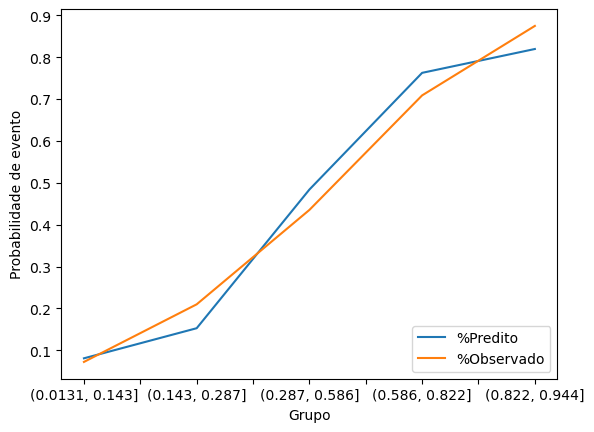

In [30]:
# Gráfico: Valor Predito x Real
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

#Criando dois gráficos de  linha com dados diferentes
ax = qualid['pct_doentes'].plot(label='%Predito')
ax = qualid['média_pred'].plot(label='%Observado')

ax.legend(loc = 'lower right') # Posição da legenda
ax.set_ylabel('Probabilidade de evento')
ax.set_xlabel('Grupo')

> Valores preditos estão bastante próximos dos valores reais.

5. Avalie o seu modelo quanto a discriminação calculando acurácia, GINI e KS.

In [33]:
df.head(3)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente,predito
0,63.0,homem,angina típica,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0,0.458229
1,67.0,homem,assintomático,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1,0.944123
2,67.0,homem,assintomático,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1,0.886566


In [34]:
# Acurácia
acc = metrics.accuracy_score(df['flag_doente'], df['predito']>.5)
print('Acurácia: {0:.2f}%'.format(acc*100))

Acurácia: 79.54%


In [36]:
# AUC
fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['predito'])
auc_ = metrics.auc(fpr, tpr)
print('AUC: {0:.2f}%'.format(auc_*100))

AUC: 85.19%


In [37]:
# Gini
gini = 2*auc_ -1
print('GINI: {0:.2f}%'.format(gini*100))

GINI: 70.39%


In [38]:
# KS
ks = ks_2samp(df.loc[df['flag_doente'] == 1, 'predito'], df.loc[df['flag_doente'] != 1, 'predito']).statistic
print('KS: {0:.2f}%'.format(ks*100))

KS: 59.30%


6. tente melhorar o modelo obtido, por exemplo inserindo ou removendo variáveis.  
    Avalie as características do seu modelo (calibragem e acurácia).

In [59]:
reglog = smf.logit("flag_doente ~ sex + cp + trestbps + age + oldpeak", data = df).fit()
reglog.summary()

Optimization terminated successfully.
         Current function value: 0.430993
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      295
Method:                           MLE   Df Model:                            7
Date:                Sat, 23 Sep 2023   Pseudo R-squ.:                  0.3751
Time:                        14:01:55   Log-Likelihood:                -130.59
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 1.511e-30
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -6.0852      1.451     -4.192      0.000      -8.930      -3.240
sex[T.mulher]           -1.7583      0.375     -4.686      0.000      -2.494      -1.023
cp[T.angina típica]     -0.7788      0.676     -1.153      0.249      -2.103       0.545
cp[T.assintomático]      1.9524      0.461      4.239      0.000       1.050       2.855
cp[T.dor não-angina]    -0.4780      0.522     -0.917      0.359      -1.500       0.544
trestbps                 0.0166      0.009      1.804      0.071      -0.001       0.035
age                      0.0486      0.019      2.611      0.009       0.012       0.085
oldpeak                  0.8014      0.170      4.726      0.000       0.469       1.134
========================================================================================
"""

In [60]:
# Probabilidade de evento predita
df['predito'] = reglog.predict(df)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente,predito
0,63.0,homem,angina típica,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0,0.612476
1,67.0,homem,assintomático,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1,0.952214
2,67.0,homem,assintomático,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1,0.961121
3,37.0,homem,dor não-angina,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0,0.551306
4,41.0,mulher,angina atípica,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0,0.071572


In [61]:
# Categorizando probabilidade em 5 grupos
cat_pred = pd.qcut(df['predito'], 5, duplicates = 'drop')
cat_pred.value_counts().sort_index()

(0.0067, 0.11]    61
(0.11, 0.279]     60
(0.279, 0.566]    61
(0.566, 0.844]    60
(0.844, 0.995]    61
Name: predito, dtype: int64

In [62]:
# Agrupando dataframe original com base na categorização das predições
group_reg = df.groupby(cat_pred)

In [63]:
# Contagem de indivíduos por grupo
qualid = group_reg[['flag_doente']].count().rename(columns = {'flag_doente': 'indivíduos'})
qualid

,indivíduos
predito,
"(0.0067, 0.11]",61
"(0.11, 0.279]",60
"(0.279, 0.566]",61
"(0.566, 0.844]",60
"(0.844, 0.995]",61


In [64]:
# Média do valor predito por grupo
qualid['média_pred'] = group_reg['predito'].mean()
qualid

,indivíduos,média_pred
predito,,
"(0.0067, 0.11]",61,0.054526
"(0.11, 0.279]",60,0.180038
"(0.279, 0.566]",61,0.417091
"(0.566, 0.844]",60,0.716072
"(0.844, 0.995]",61,0.925652


In [65]:
# Calculando a média dos valores observados
qualid['pct_doentes'] = group_reg['flag_doente'].mean()
qualid

,indivíduos,média_pred,pct_doentes
predito,,,
"(0.0067, 0.11]",61,0.054526,0.065574
"(0.11, 0.279]",60,0.180038,0.183333
"(0.279, 0.566]",61,0.417091,0.393443
"(0.566, 0.844]",60,0.716072,0.716667
"(0.844, 0.995]",61,0.925652,0.934426


In [66]:
# Acurácia
acc = metrics.accuracy_score(df['flag_doente'], df['predito']>.5)
print('Acurácia: {0:.2f}%'.format(acc*100))

Acurácia: 80.53%


> Foi alcançada uma pequena melhora na acurácia do modelo com o acréscimo da variável 'oldpeak'.